#https://vitalflux.com/autoregressive-ar-models-with-python-examples/

#https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
Autocorrelation
* An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step.

* This relationship between variables is called correlation.

* If both variables change in the same direction (e.g. go up together or down together), this is called a positive correlation. If the variables move in opposite directions as values change (e.g. one goes up and one goes down), then this is called negative correlation.

* We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling.

* Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation. It is also called serial correlation because of the sequenced structure of time series data.

* The correlation statistics can also help to choose which lag variables will be useful in a model and which will not.

* Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable. This can be very useful when getting started on a new dataset.

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from numpy import log
import numpy as np
import warnings

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

## Sample Autoregression Model

<AxesSubplot:xlabel='Month'>

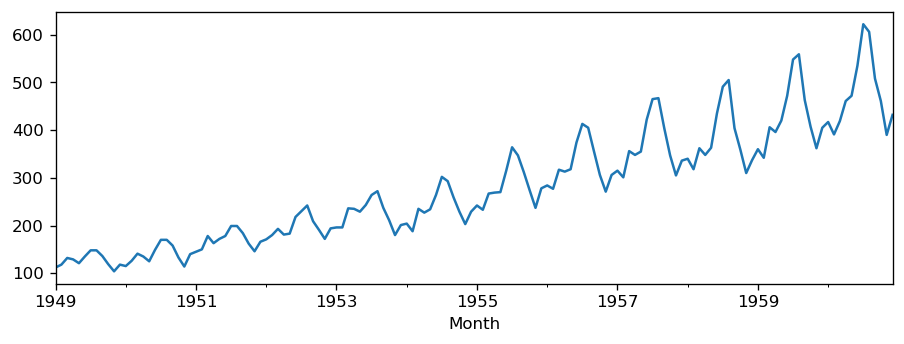

In [5]:
'''
‘Stationarity’ is one of the most important concepts you will come across when working with time series data. 
A stationary series is one in which the properties – mean, variance and covariance, do not vary with time.
'''
#reading the dataset
train = pd.read_csv('AirPassengers.csv')

#preprocessing
train.timestamp = pd.to_datetime(train.Month , format = '%Y-%m')
train.index = train.timestamp
train.drop('Month',axis = 1, inplace = True)

train['#Passengers'].plot()

In [6]:
'''
ADF (Augmented Dickey Fuller) Test
The Dickey Fuller test is one of the most popular statistical tests. 
It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. 
The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. 
This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section).

Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). 
When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary
'''
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(train['#Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


<AxesSubplot:xlabel='Month'>

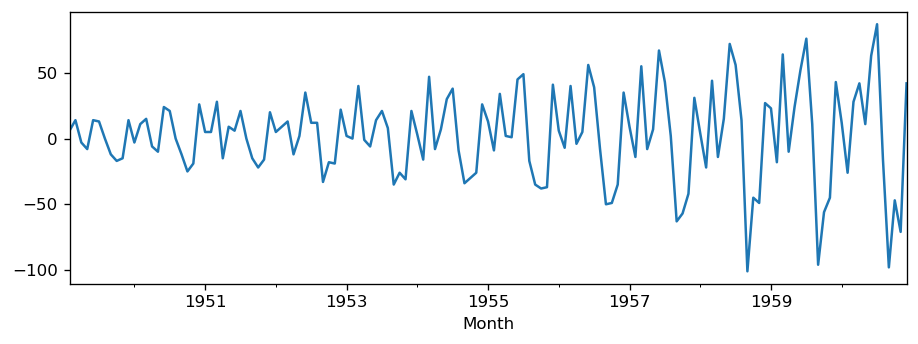

In [7]:
'''
Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first.

Differencing
In this method, we compute the difference of consecutive terms in the series. 
Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

yt‘ = yt – y(t-1)

where yt is the value at a time t
'''
train['#Passengers_diff'] = train['#Passengers'] - train['#Passengers'].shift(1)
train['#Passengers_diff'].dropna().plot()

<AxesSubplot:xlabel='Month'>

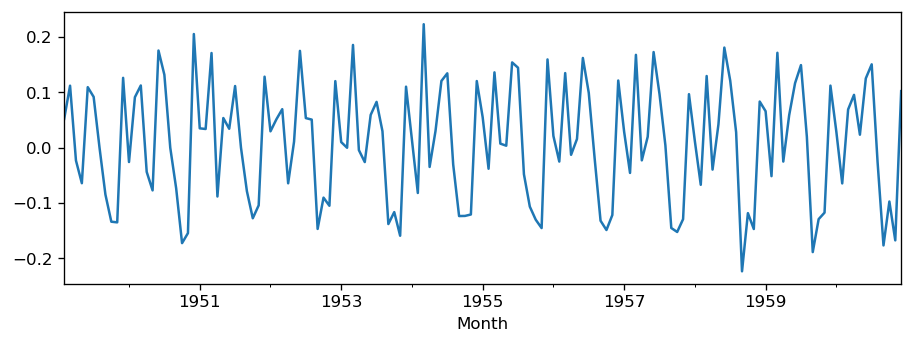

In [8]:
'''
Transformation
Transformations are used to stabilize the non-constant variance of a series. 
Common transformation methods include power transform, square root, and log transform. 
Let’s do a quick log transform and differencing on our air passenger dataset:
'''
train['#Passengers_log'] = np.log(train['#Passengers'])
train['#Passengers_log_diff'] = train['#Passengers_log'] - train['#Passengers_log'].shift(1)
train['#Passengers_log_diff'].dropna().plot()


## Forecasting a Time Series

In [9]:
''' 
ARIMA stands for Auto-Regressive Integrated Moving Averages. 
The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. 
The predictors depend on the parameters (p,d,q) of the ARIMA model:

Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. 
For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. 
So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. 
For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. 

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

'''
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.464240
p-value: 0.124419


In [20]:
'''
auto.arima() function, the pmdarima package provides auto_arima() with similar functionality.

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least 

'''
model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.00 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

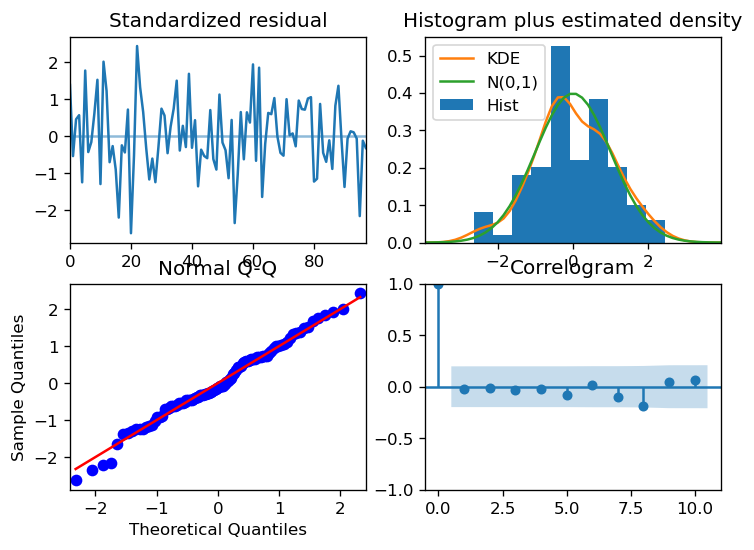

In [18]:
''' 
Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.
Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. 
'''
model.plot_diagnostics(figsize=(7,5))
plt.show()

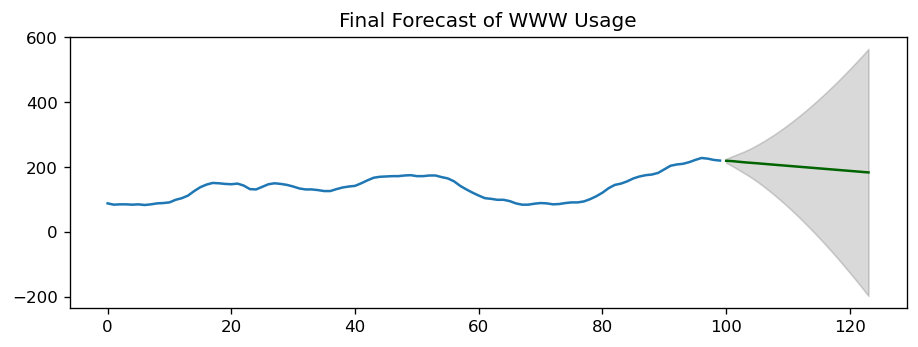

In [19]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()